In [1]:
!pip install opendatasets plotly --quiet
import opendatasets as od
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import plotly.express as px
from matplotlib.ticker import FuncFormatter
import plotly.subplots as sp
import plotly.graph_objects as go
from matplotlib.dates import MonthLocator, DateFormatter
import datetime
import matplotlib.ticker as ticker
import jovian

<IPython.core.display.Javascript object>

In [2]:
# Read the train.csv file
train_df = pd.read_csv('./ashrae-energy-prediction/train.csv',parse_dates=['timestamp'])

weather_train_df= pd.read_csv('./ashrae-energy-prediction/weather_train.csv',parse_dates=['timestamp'])

meta_df = pd.read_csv('./ashrae-energy-prediction/building_metadata.csv',parse_dates=['year_built'])

**DATA DESCRIPTION**

**CONVERT TIMESTAMP AS DATETIME FORMAT**


In [3]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
meta_df['year_built'] = pd.to_datetime(meta_df['year_built'])


In [4]:
train_df.head(5)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


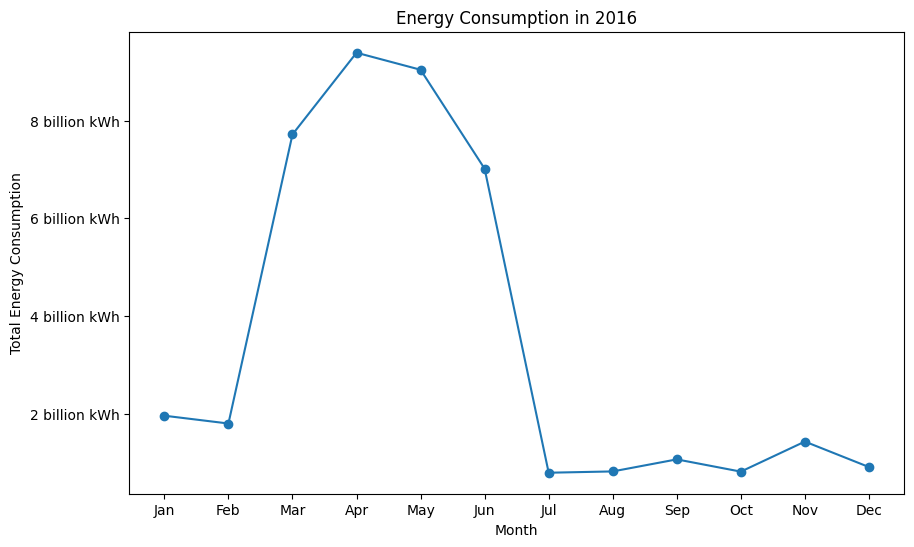

In [5]:

train_df['month'] = train_df['timestamp'].dt.month


monthly_energy = train_df.groupby('month')['meter_reading'].sum()


plt.figure(figsize=(10, 6))
plt.plot(monthly_energy.index, monthly_energy, marker='o')


plt.xlabel('Month')
plt.ylabel('Total Energy Consumption')
plt.title('Energy Consumption in 2016')

month_names = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS').strftime('%b')
plt.xticks(monthly_energy.index, month_names)

# Format the y-axis labels as billion kWh or million kWh
def energy_formatter(x, pos):
    if x >= 1e9:
        return f'{x / 1e9:.0f} billion kWh'
    elif x >= 1e6:
        return f'{x / 1e6:.0f} million kWh'
    else:
        return f'{x / 1e3:.0f} thousand kWh'

formatter = FuncFormatter(energy_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Show the plot
plt.show()


In [6]:
weather_train_df.sample(5)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
133430,15,2016-04-02 20:00:00,3.9,NaN,0.0,5.0,996.3,0.0,0.0
57892,6,2016-08-06 13:00:00,24.4,0.0,22.8,0.0,1010.6,220.0,1.5
126612,14,2016-06-18 21:00:00,30.6,4.0,10.0,0.0,1022.0,330.0,2.1
49021,5,2016-08-02 17:00:00,18.0,NaN,18.0,NaN,NaN,270.0,6.7
55200,6,2016-04-16 09:00:00,5.0,0.0,0.0,0.0,1028.7,260.0,2.1


CONVERT DATATYPES

In [7]:
train_df=train_df.astype({'building_id':'int16','meter':'int8','meter_reading':'float32'})


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          int8          
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
 4   month          int32         
dtypes: datetime64[ns](1), float32(1), int16(1), int32(1), int8(1)
memory usage: 366.3 MB


In [9]:
weather_train_df=weather_train_df.astype({'site_id':'int8','air_temperature':'float16',
                       'cloud_coverage':'float16','dew_temperature':'float16',
                       'precip_depth_1_hr':'float16','sea_level_pressure':'float16'
                       ,'wind_speed':'float16','wind_direction':'float16'
                       })

In [10]:
weather_train_df['site_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int8)

In [11]:
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int8          
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float16       
 3   cloud_coverage      70600 non-null   float16       
 4   dew_temperature     139660 non-null  float16       
 5   precip_depth_1_hr   89484 non-null   float16       
 6   sea_level_pressure  129155 non-null  float16       
 7   wind_direction      133505 non-null  float16       
 8   wind_speed          139469 non-null  float16       
dtypes: datetime64[ns](1), float16(7), int8(1)
memory usage: 3.1 MB


In [12]:
#lets create a hourly based 
temp_df=weather_train_df[['site_id','timestamp','air_temperature']]
temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_20468\2007883584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')


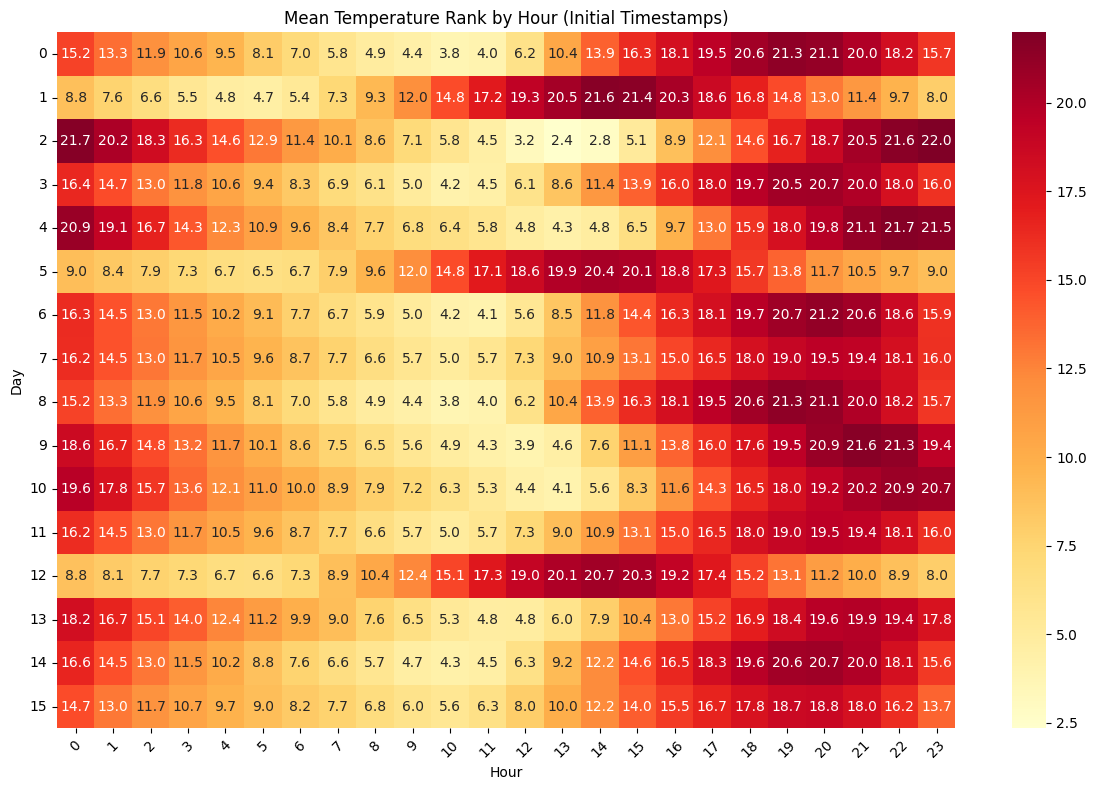

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_2d, cmap='YlOrRd', annot=True, fmt=".1f", cbar=True)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.title('Mean Temperature Rank by Hour (Initial Timestamps)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
def time_alignment(df):
    temp_df=df[['site_id','timestamp','air_temperature']]
    

    temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
    
    # create 2D dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
    df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)
    

    df_2d = df_2d / df_2d.max(axis=1).values.reshape((-1,1))
    

    site_ids_argmax_maxtemp=pd.Series(np.argmax(df_2d.values,axis=1)).sort_values().index
  
    site_ids_offsets= pd.Series(df_2d.values.argmax(axis=1) - 14)

    df_2d=df_2d.iloc[site_ids_argmax_maxtemp]
    temp_df['offset'] = temp_df.site_id.map(site_ids_offsets)

    temp_df['timestamp_aligned'] = (temp_df.timestamp - pd.to_timedelta(temp_df.offset, unit='H'))
 
    df['timestamp']=temp_df['timestamp_aligned']
    return df 

In [15]:
time_alignment(weather_train_df) 

C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_20468\1718289178.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_20468\1718289178.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['offset'] = temp_df.site_id.map(site_ids_offsets)
C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_20468\1718289178.py:21: Setting

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2015-12-31 19:00:00,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,0,2015-12-31 20:00:00,24.406250,NaN,21.093750,-1.0,1020.0,70.0,1.500000
2,0,2015-12-31 21:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000
3,0,2015-12-31 22:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000
4,0,2015-12-31 23:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 13:00:00,3.000000,NaN,-8.000000,NaN,NaN,180.0,5.699219
139769,15,2016-12-31 14:00:00,2.800781,2.0,-8.898438,NaN,1007.5,180.0,7.699219
139770,15,2016-12-31 15:00:00,2.800781,NaN,-7.199219,NaN,1007.5,180.0,5.101562
139771,15,2016-12-31 16:00:00,2.199219,NaN,-6.699219,NaN,1008.0,170.0,4.601562


In [16]:
#lets create a hourly based 
temp_df=weather_train_df[['site_id','timestamp','air_temperature']]
temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')
df_2d=temp_df.groupby(['site_id', temp_df.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_20468\2007883584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['temp_rank']=temp_df.groupby(['site_id', temp_df.timestamp.dt.date],)['air_temperature'].rank('average')


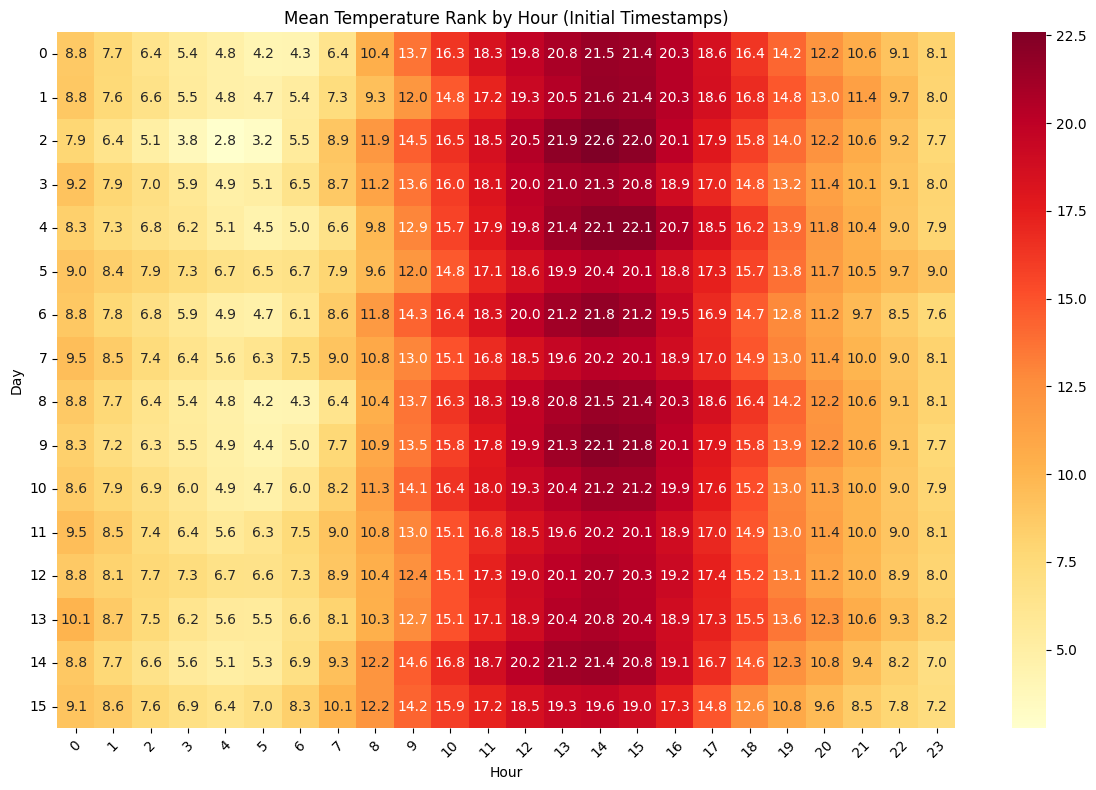

In [17]:



plt.figure(figsize=(12, 8))
sns.heatmap(df_2d, cmap='YlOrRd', annot=True, fmt=".1f", cbar=True)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.title('Mean Temperature Rank by Hour (Initial Timestamps)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [18]:
meta_df=meta_df.astype({'site_id':'int8','building_id':'int16',
                       'square_feet':'int16'
                       })

In [19]:
meta_df['site_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int8)

In [20]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   site_id      1449 non-null   int8          
 1   building_id  1449 non-null   int16         
 2   primary_use  1449 non-null   object        
 3   square_feet  1449 non-null   int16         
 4   year_built   675 non-null    datetime64[ns]
 5   floor_count  355 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int16(2), int8(1), object(1)
memory usage: 41.2+ KB


**LETS SEE HOW MANY BUILDINGS ARE THERE IN EACH SITE**

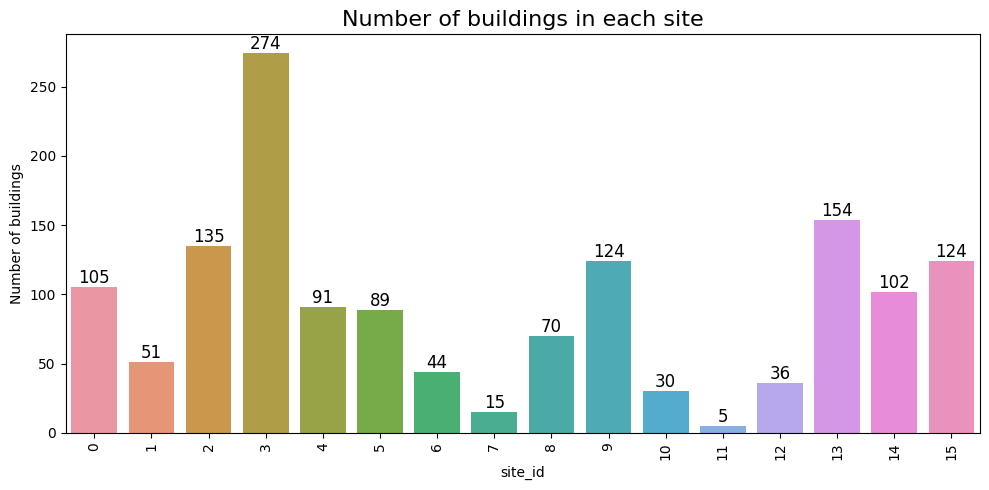

In [21]:



fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.countplot(data=meta_df, x='site_id', ax=ax)

for p in ax.patches:
    height = int(p.get_height())  # Convert the count to an integer
    ax.annotate(height, (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom', fontsize=12)


ax.set_xlabel('site_id')
ax.set_ylabel('Number of buildings')
ax.set_title('Number of buildings in each site', fontsize=16)


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


C:\Users\asif.abbas_ucamind\AppData\Local\Temp\ipykernel_20468\3482236498.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)


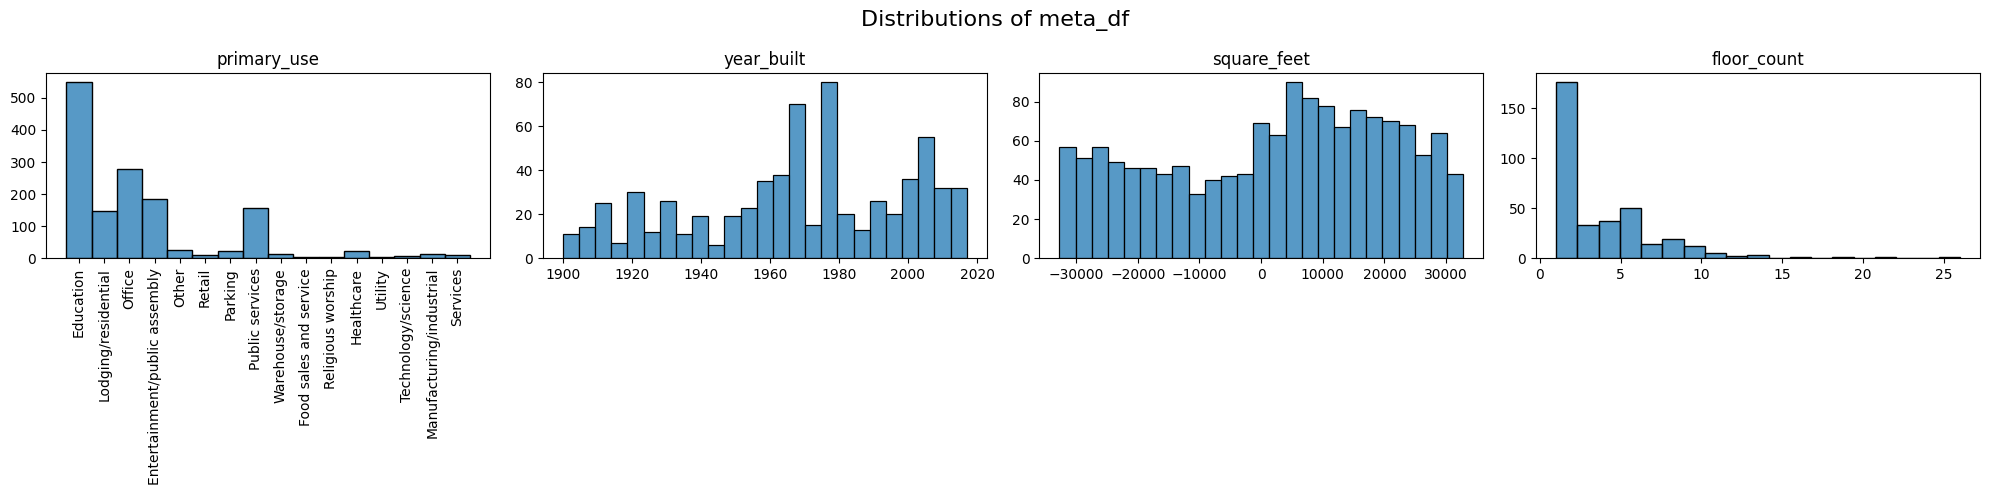

In [22]:



fig, axes = plt.subplots(1, 4, figsize=(20, 5))


for i, col in enumerate(['primary_use', 'year_built', 'square_feet', 'floor_count']):
    if col == 'primary_use':
        sns.histplot(data=meta_df, x=col, ax=axes[i], bins=min(25, len(meta_df[col].unique())))
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    else:
        sns.histplot(data=meta_df, x=col, ax=axes[i], bins=min(25, len(meta_df[col].unique())))
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')


fig.suptitle('Distributions of meta_df', fontsize=16)


plt.tight_layout()


plt.show()


In [23]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   site_id      1449 non-null   int8          
 1   building_id  1449 non-null   int16         
 2   primary_use  1449 non-null   object        
 3   square_feet  1449 non-null   int16         
 4   year_built   675 non-null    datetime64[ns]
 5   floor_count  355 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int16(2), int8(1), object(1)
memory usage: 41.2+ KB


**CREATING A SINGLE DF**

In [24]:
merged_df = train_df.merge(meta_df, on='building_id', how='left')
df= merged_df.merge(weather_train_df,on=['site_id','timestamp'],how='left')

In [25]:
df['site_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int8)

In [26]:
df.head(3)

,building_id,meter,timestamp,meter_reading,month,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,1,0,Education,7432,2008-01-01,NaN,19.40625,NaN,19.40625,0.0,NaN,0.0,0.0
1,1,0,2016-01-01,0.0,1,0,Education,2720,2004-01-01,NaN,19.40625,NaN,19.40625,0.0,NaN,0.0,0.0
2,2,0,2016-01-01,0.0,1,0,Education,5376,1991-01-01,NaN,19.40625,NaN,19.40625,0.0,NaN,0.0,0.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 17 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int16         
 1   meter               int8          
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   month               int32         
 5   site_id             int8          
 6   primary_use         object        
 7   square_feet         int16         
 8   year_built          datetime64[ns]
 9   floor_count         float64       
 10  air_temperature     float16       
 11  cloud_coverage      float16       
 12  dew_temperature     float16       
 13  precip_depth_1_hr   float16       
 14  sea_level_pressure  float16       
 15  wind_direction      float16       
 16  wind_speed          float16       
dtypes: datetime64[ns](2), float16(7), float32(1), float64(1), int16(2), int32(1), int8(2), object(1)
memory usage: 1.1+ GB


In [28]:
del merged_df,train_df,meta_df #Remove unused variables to free up memeory

**TAKING CARE OF MISSING VALUES**

In [29]:
df.isna().sum()*100/len(df)

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
month                  0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            59.990033
floor_count           82.652772
air_temperature        0.542231
cloud_coverage        43.685335
dew_temperature        0.559455
precip_depth_1_hr     18.593022
sea_level_pressure     6.146022
wind_direction         7.229614
wind_speed             0.774551
dtype: float64

In [30]:
median_year = df['year_built'].median() #filling the year missing values with the median value
df['year_built'].fillna(median_year, inplace=True)
df['cloud_coverage'].fillna(-1, inplace=True)#replacing the missing values in cloud_coverage with -1, here -1 will be considered as missing values where 0-9 is the different oktas value
# Convert object columns to categorical to save memeory usage
df['meter'] = df['meter'].astype('category')
df['primary_use'] = df['primary_use'].astype('category')

In [31]:
df.sample()

,building_id,meter,timestamp,meter_reading,month,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
3692494,30,0,2016-03-10 17:00:00,0.0,3,0,Education,28361,1999-01-01,NaN,28.296875,4.0,15.0,0.0,1021.0,130.0,6.199219


**DATA DESCRIPTION**

train.csv
- building_id - Foreign key for the building metadata.
- meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
- timestamp - When the measurement was taken
- meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.

building_meta.csv
- site_id - Foreign key for the weather files.
- building_id - Foreign key for training.csv
- primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
- square_feet - Gross floor area of the building
- year_built - Year building was opened
- floor_count - Number of floors of the building

weather_[train/test].csv
Weather data from a meteorological station as close as possible to the site.

- site_id
- air_temperature - Degrees Celsius
- cloud_coverage - Portion of the sky covered in clouds, in oktas
- dew_temperature - Degrees Celsius
- precip_depth_1_hr - Millimeters
- sea_level_pressure - Millibar/hectopascals
- wind_direction - Compass direction (0-360)
- wind_speed - Meters per second

**LETS MAP METER ID CODE AS PER THE DESCRIPTION**

In [32]:
meter_labels = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
df['meter'] = df['meter'].map(meter_labels)

**REMOVING COLUMNS TO REDUCE THE MEMORY USAGE**

In [33]:
df.drop(['floor_count', 'precip_depth_1_hr', 'sea_level_pressure'], axis=1, inplace=True)


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 14 columns):
 #   Column           Dtype         
---  ------           -----         
 0   building_id      int16         
 1   meter            category      
 2   timestamp        datetime64[ns]
 3   meter_reading    float32       
 4   month            int32         
 5   site_id          int8          
 6   primary_use      category      
 7   square_feet      int16         
 8   year_built       datetime64[ns]
 9   air_temperature  float16       
 10  cloud_coverage   float16       
 11  dew_temperature  float16       
 12  wind_direction   float16       
 13  wind_speed       float16       
dtypes: category(2), datetime64[ns](2), float16(5), float32(1), int16(2), int32(1), int8(1)
memory usage: 790.5 MB


In [35]:
df.sample(3)

,building_id,meter,timestamp,meter_reading,month,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,wind_direction,wind_speed
9866199,692,electricity,2016-06-30 10:00:00,6.330000,6,5,Office,7416,1976-01-01,15.000000,-1.0,12.000000,270.0,3.599609
17592618,571,electricity,2016-11-15 02:00:00,17.500000,11,4,Education,-17582,1980-01-01,14.398438,-1.0,13.296875,290.0,3.599609
2244398,292,electricity,2016-02-10 17:00:00,157.389999,2,3,Public services,-31793,1969-01-01,0.000000,-1.0,-11.101562,300.0,6.199219


In [36]:
df['square_feet'].nunique()

1385

**LETS CONVERT SITE_ID 0 METER READINGS FROM kBTU to kWh**

In [37]:
df.loc[df['site_id'] == 0, 'meter_reading'] *= 0.2931

In [38]:
df[df['building_id'] == 1099]

,building_id,meter,timestamp,meter_reading,month,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,wind_direction,wind_speed
1533,1099,electricity,2016-01-01 00:00:00,2.822480e+02,1,13,Education,5204,1969-01-01,-6.699219,-1.0,-10.000000,280.0,4.101562
1534,1099,steam,2016-01-01 00:00:00,3.241630e+06,1,13,Education,5204,1969-01-01,-6.699219,-1.0,-10.000000,280.0,4.101562
3829,1099,electricity,2016-01-01 01:00:00,2.822480e+02,1,13,Education,5204,1969-01-01,-6.699219,-1.0,-9.398438,260.0,2.599609
3830,1099,steam,2016-01-01 01:00:00,3.241630e+06,1,13,Education,5204,1969-01-01,-6.699219,-1.0,-9.398438,260.0,2.599609
6125,1099,electricity,2016-01-01 02:00:00,2.848640e+02,1,13,Education,5204,1969-01-01,-6.699219,-1.0,-9.398438,250.0,3.599609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210589,1099,steam,2016-12-31 21:00:00,4.800000e+03,12,13,Education,5204,1969-01-01,NaN,-1.0,NaN,NaN,NaN
20212955,1099,electricity,2016-12-31 22:00:00,2.660220e+02,12,13,Education,5204,1969-01-01,NaN,-1.0,NaN,NaN,NaN
20212956,1099,steam,2016-12-31 22:00:00,4.896000e+03,12,13,Education,5204,1969-01-01,NaN,-1.0,NaN,NaN,NaN
20215320,1099,electricity,2016-12-31 23:00:00,2.636890e+02,12,13,Education,5204,1969-01-01,NaN,-1.0,NaN,NaN,NaN


**EXPLOITORY DATA ANALYSIS** 

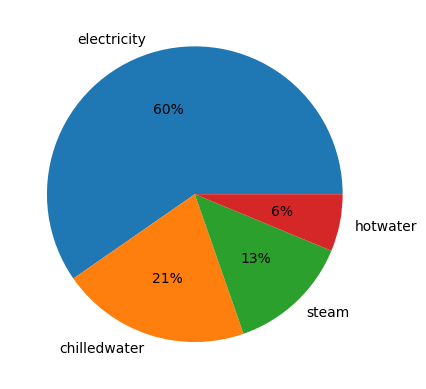

In [39]:


# Create the pie chart
fig = plt.pie(df['meter'].value_counts().values, 
             labels=df['meter'].value_counts().index,autopct='%.0f%%',
             )

plt.show()

In [87]:
import plotly.graph_objects as go
import plotly.subplots as sp

df_subset = df[['site_id', 'timestamp', 'meter_reading']]

fig = sp.make_subplots(rows=8, cols=2, subplot_titles=[f"Site {site_id}" for site_id in range(16)])

desired_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

for i, site_id in enumerate(range(16)):
    site_data = df_subset[df_subset['site_id'] == site_id].copy()  # Make a copy of the DataFrame
    
    site_data.loc[:, 'day_of_week'] = site_data['timestamp'].dt.strftime('%A')  # Use .loc to modify the DataFrame
    
    daily_data = site_data.groupby('day_of_week')['meter_reading'].sum()
    daily_data = daily_data.reindex(desired_order)
    
    trace = go.Scatter(x=daily_data.index, y=daily_data, mode='lines', name='Energy Consumption')
    
    fig.add_trace(trace, row=(i // 2) + 1, col=(i % 2) + 1)

fig.update_layout(height=1200, width=1000, showlegend=False)

fig.show()


In [88]:
del site_data

**ENERGY DISTRIBUTION FOR 7 DAYS IN A WEEK FOR DIFFERENT SITE_ID**

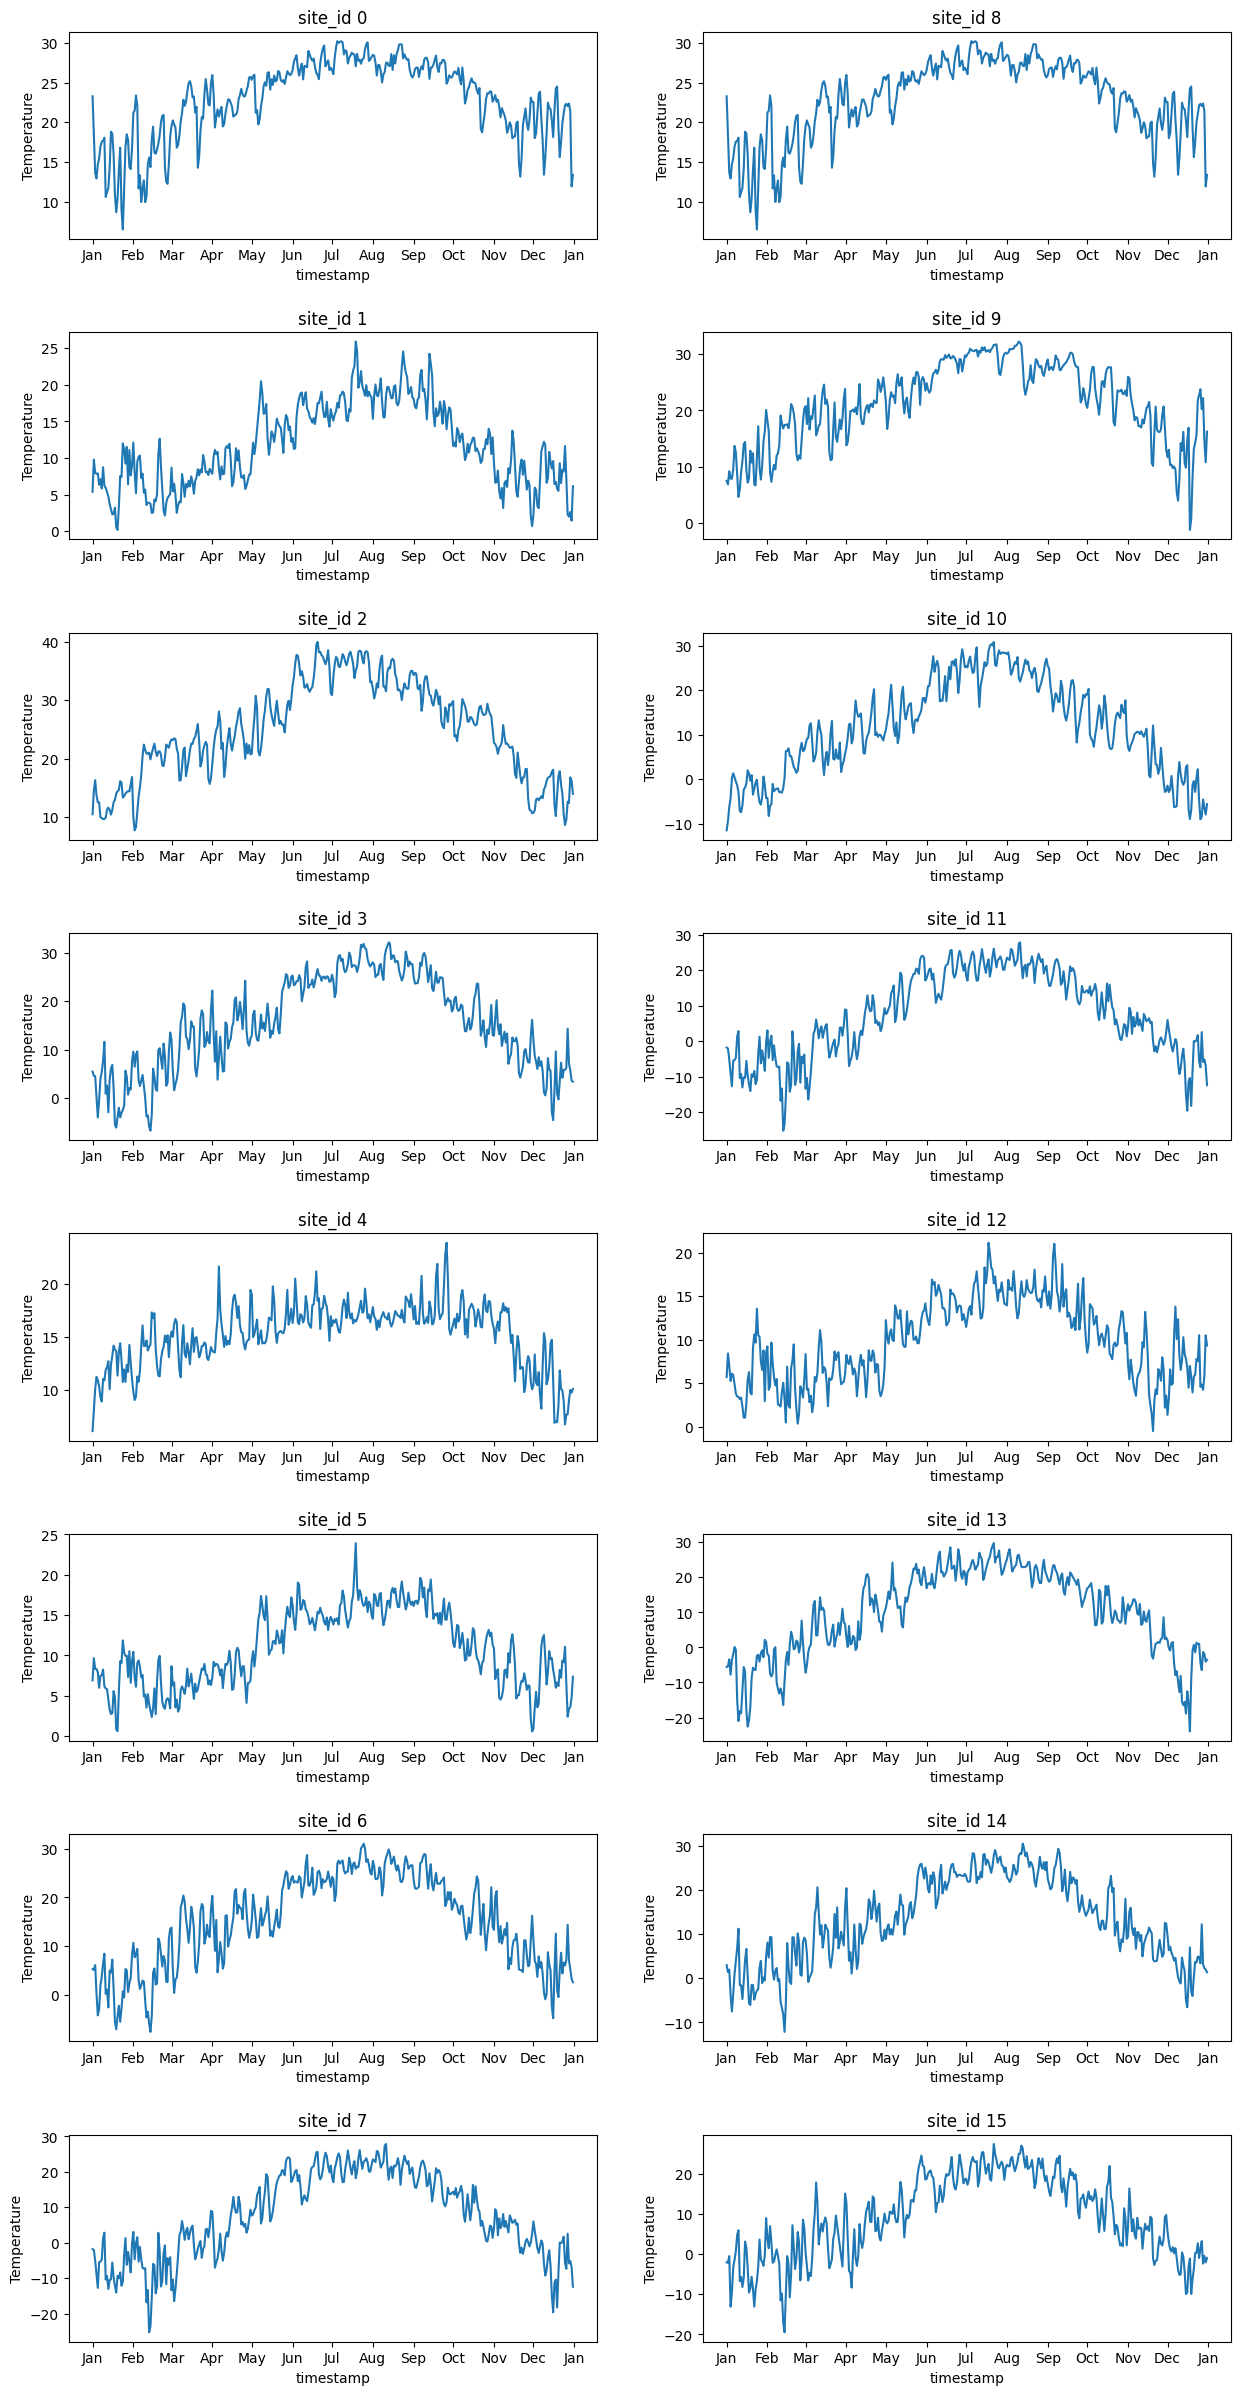

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import MonthLocator, DateFormatter



subset_df = df.loc[:, ['site_id', 'timestamp', 'air_temperature']].copy()



# Create the plot using the subset dataset
fig, ax = plt.subplots(8, 2, figsize=(15, 30))
for i in range(16):
    ax[i % 8][i // 8].xaxis.set_major_locator(MonthLocator())
    ax[i % 8][i // 8].xaxis.set_major_formatter(DateFormatter('%b'))
    sns.lineplot(
        data=subset_df[subset_df['site_id'] == i].set_index('timestamp').resample('D').mean()['air_temperature'],
        ax=ax[i % 8][i // 8]
    )
    ax[i % 8][i // 8].set_ylabel('Temperature')
    ax[i % 8][i // 8].set_title('site_id {}'.format(i))
    plt.subplots_adjust(hspace=0.45)

plt.show()


In [43]:
del subset_df


**BUILDING AGE AND ENERGY CONSUMPTION**

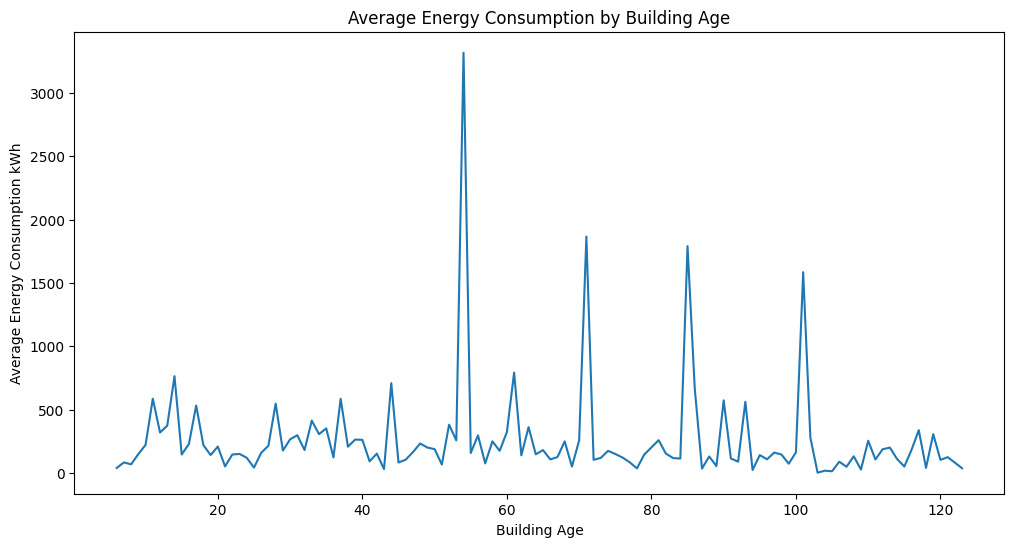

In [44]:


# Calculate the current year
current_year = datetime.datetime.now().year

# Calculate the building age by subtracting the year of construction from the current year
df['building_age'] = current_year - pd.to_datetime(df['year_built']).dt.year

# Filter the DataFrame to include only necessary columns and drop missing values
df_subset = df[['building_age', 'meter_reading']]
# Calculate the average energy consumption by building age
avg_energy_consumption = df_subset.groupby('building_age')['meter_reading'].mean().reset_index()

# Create the line plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=avg_energy_consumption, x='building_age', y='meter_reading', ax=ax)

# Set the x-axis label
ax.set_xlabel('Building Age')

# Set the y-axis label
ax.set_ylabel('Average Energy Consumption kWh')

# Set the plot title
ax.set_title('Average Energy Consumption by Building Age')


# Show the plot
plt.show()

In [45]:
del df_subset

There is a significant hike in between the age of 40-60 Lets find out what building_id is giving that value

Before that lets also see How the values of Total meter reading shows with repect to the building_id

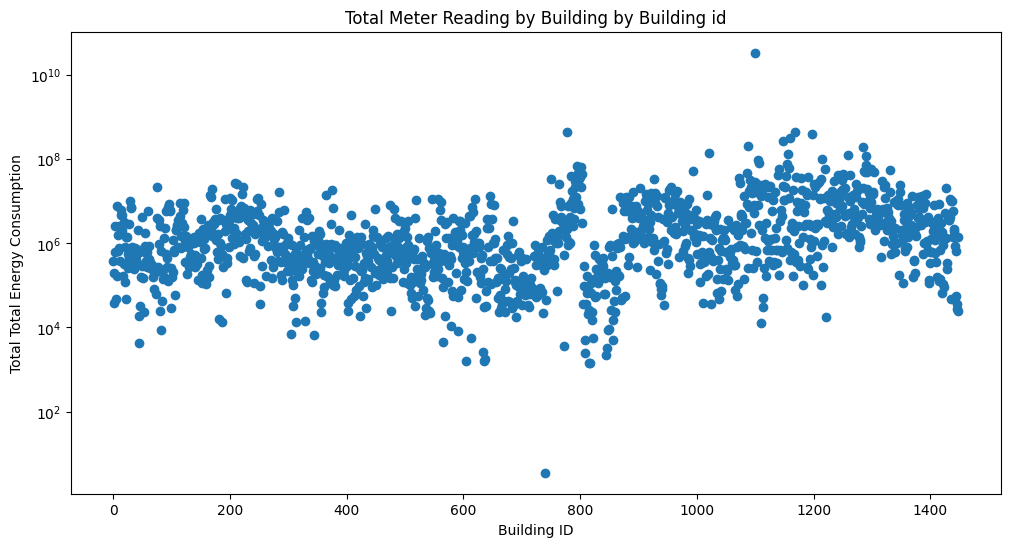

In [46]:

total_meter_reading = df.groupby('building_id')['meter_reading'].sum().reset_index()


plt.figure(figsize=(12, 6))
plt.scatter(total_meter_reading['building_id'], total_meter_reading['meter_reading'])
plt.xlabel('Building ID')
plt.ylabel('Total Total Energy Consumption')
plt.title('Total Meter Reading by Building by Building id')
plt.yscale('log')  # Apply logarithmic scale to y-axis


plt.show()

As we can notice that most of the values lie between 10<sup>4</sup> to 10<sup>8</sup>, But there are two outliers lets find out what is the building_id of these two outliers

In [56]:

total_meter_reading = df.groupby('building_id')['meter_reading'].sum().reset_index()


min_id = total_meter_reading['building_id'].iloc[total_meter_reading['meter_reading'].idxmin()]
max_id = total_meter_reading['building_id'].iloc[total_meter_reading['meter_reading'].idxmax()]


min_building = total_meter_reading[total_meter_reading['building_id'] == min_id]
max_building = total_meter_reading[total_meter_reading['building_id'] == max_id]


min_building_info = df[df['building_id'] == min_id]['primary_use'].iloc[0]
max_building_info = df[df['building_id'] == max_id]['primary_use'].iloc[0]

building_info = pd.DataFrame({
    'Building ID': [min_id, max_id],
    'Primary Use': [min_building_info, max_building_info],
    'Total Meter Reading': [min_building['meter_reading'].values[0], max_building['meter_reading'].values[0]]
})


print(building_info)

   Building ID Primary Use  Total Meter Reading
0          740   Education         3.513400e+00
1         1099   Education         3.350620e+10


As we can observe that the primary use of both the outliers are Education so keeping that in mind we must carry on with the further analysis

,index,building_id,meter,timestamp,meter_reading,month,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,wind_direction,wind_speed,building_age
0,0,0,electricity,2016-01-01 00:00:00,0.000000,1,0,Education,7432,2008-01-01,19.40625,-1.0,19.40625,0.0,0.0,15
1,1,1,electricity,2016-01-01 00:00:00,0.000000,1,0,Education,2720,2004-01-01,19.40625,-1.0,19.40625,0.0,0.0,19
2,2,2,electricity,2016-01-01 00:00:00,0.000000,1,0,Education,5376,1991-01-01,19.40625,-1.0,19.40625,0.0,0.0,32
3,3,3,electricity,2016-01-01 00:00:00,0.000000,1,0,Education,23685,2002-01-01,19.40625,-1.0,19.40625,0.0,0.0,21
4,4,4,electricity,2016-01-01 00:00:00,0.000000,1,0,Education,-14465,1975-01-01,19.40625,-1.0,19.40625,0.0,0.0,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20189745,20216095,1444,electricity,2016-12-31 23:00:00,8.750000,12,15,Entertainment/public assembly,19619,1914-01-01,NaN,-1.0,NaN,NaN,NaN,109
20189746,20216096,1445,electricity,2016-12-31 23:00:00,4.825000,12,15,Education,4298,1969-01-01,NaN,-1.0,NaN,NaN,NaN,54
20189747,20216097,1446,electricity,2016-12-31 23:00:00,0.000000,12,15,Entertainment/public assembly,11265,1997-01-01,NaN,-1.0,NaN,NaN,NaN,26
20189748,20216098,1447,electricity,2016-12-31 23:00:00,159.574997,12,15,Lodging/residential,29775,2001-01-01,NaN,-1.0,NaN,NaN,NaN,22


In [79]:
df.shape

(20216100, 15)

In [67]:
df_filtered=df.copy() #creating a copy of dataset to not disturb the originial dataset

In [68]:
# Define the minimum and maximum building IDs
min_id = 740
max_id = 1099

# Filter the DataFrame to exclude the outliers
df_filtered = df_filtered[~df_filtered['building_id'].isin([min_id, max_id])]
df_filtered.reset_index()

# Print the shape of the filtered DataFrame
print("Shape of filtered DataFrame:", df_filtered.shape)


Shape of filtered DataFrame: (20189750, 15)


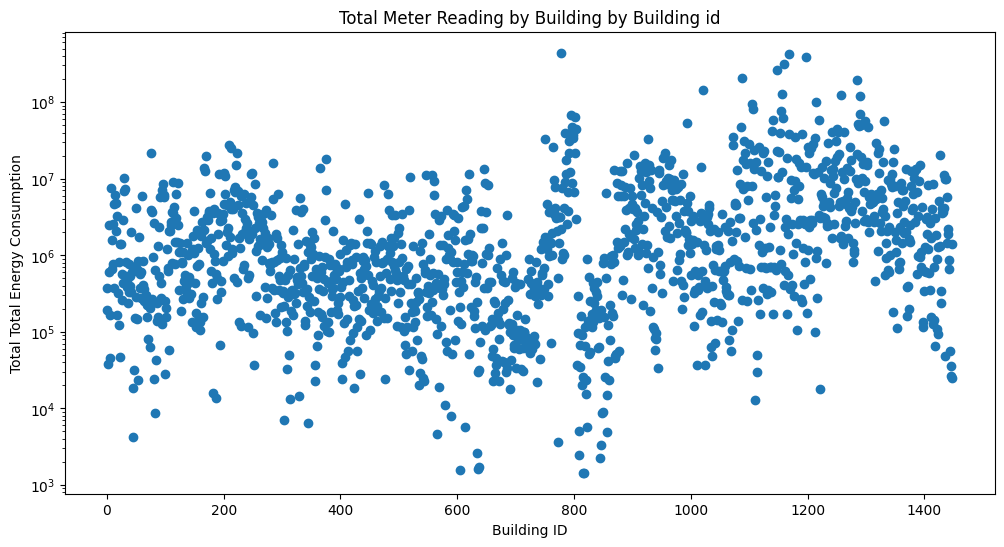

In [69]:

total_meter_reading = df_filtered.groupby('building_id')['meter_reading'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.scatter(total_meter_reading['building_id'], total_meter_reading['meter_reading'])
plt.xlabel('Building ID')
plt.ylabel('Total Total Energy Consumption')
plt.title('Total Meter Reading by Building by Building id')
plt.yscale('log')  


plt.show()

THE PLOT ABOVE LOOKS ACCEPTABLE AS ALL THE VALUES ARE WELL DISTRIBUTED

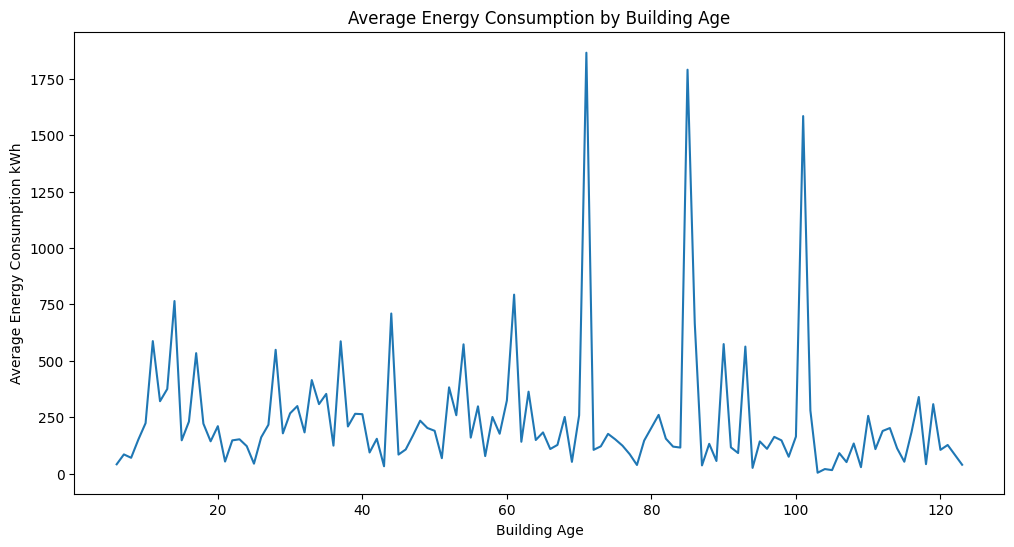

In [72]:

current_year = datetime.datetime.now().year


df_filtered['building_age'] = current_year - pd.to_datetime(df['year_built']).dt.year


df_subset = df_filtered[['building_age', 'meter_reading']]

avg_energy_consumption = df_subset.groupby('building_age')['meter_reading'].mean().reset_index()


fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=avg_energy_consumption, x='building_age', y='meter_reading', ax=ax)


ax.set_xlabel('Building Age')


ax.set_ylabel('Average Energy Consumption kWh')


ax.set_title('Average Energy Consumption by Building Age')



plt.show()

As we can see now that after filtering the dataset the average energy consumption is high after the building age has crossed 100 which is understandable 

Different meter type timeseries graph 

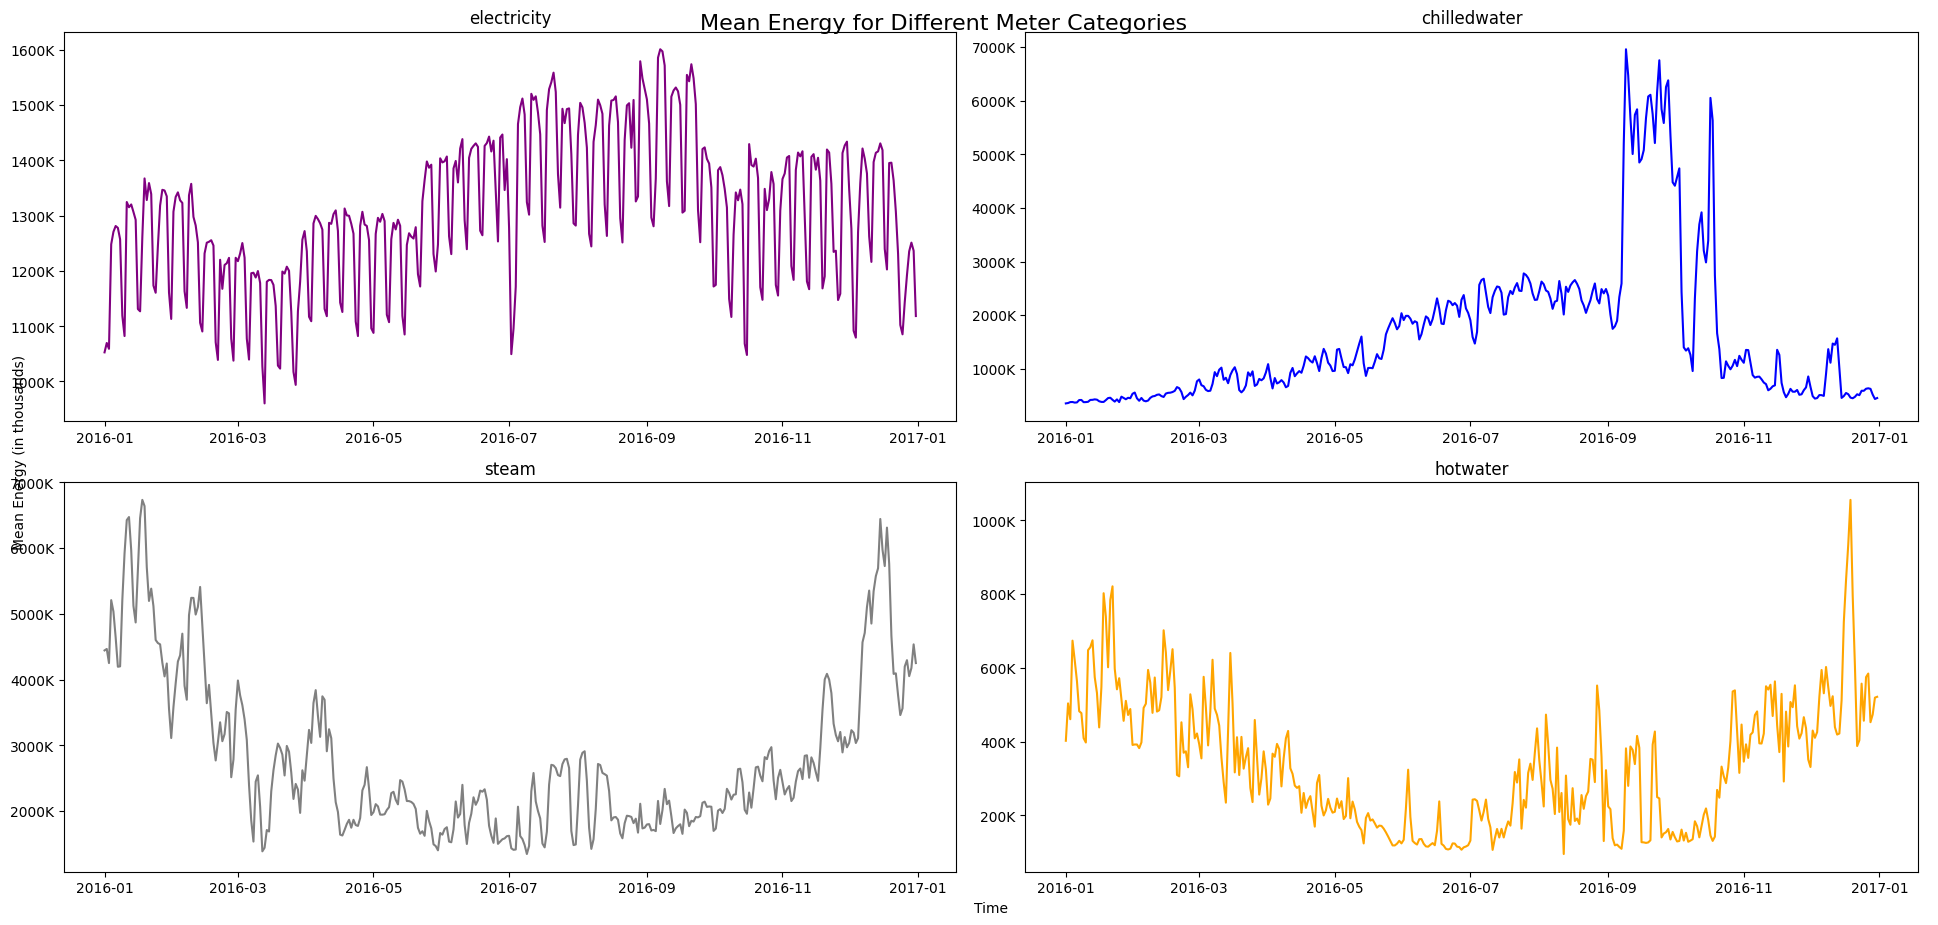

In [80]:



meters = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

colors = ['purple', 'blue', 'grey', 'orange']

for ax, m in zip(axes.flat, meters):
    filtered_df = df_filtered[df_filtered['meter'] == meters[m]]
    meter_daily = filtered_df.groupby(['meter', filtered_df['timestamp'].dt.date])['meter_reading'].sum()
    meter_daily = meter_daily.reset_index()
    mean = meter_daily.groupby('timestamp')['meter_reading'].mean()
    
    ax.plot(mean.index, mean, color=colors[m])
    ax.set_title(meters[m])
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))  # Format y-axis labels in thousands


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Time')
plt.ylabel('Mean Energy (in thousands)')

plt.suptitle('Mean Energy for Different Meter Categories', fontsize=16, y=0.94)
plt.tight_layout()
plt.show()


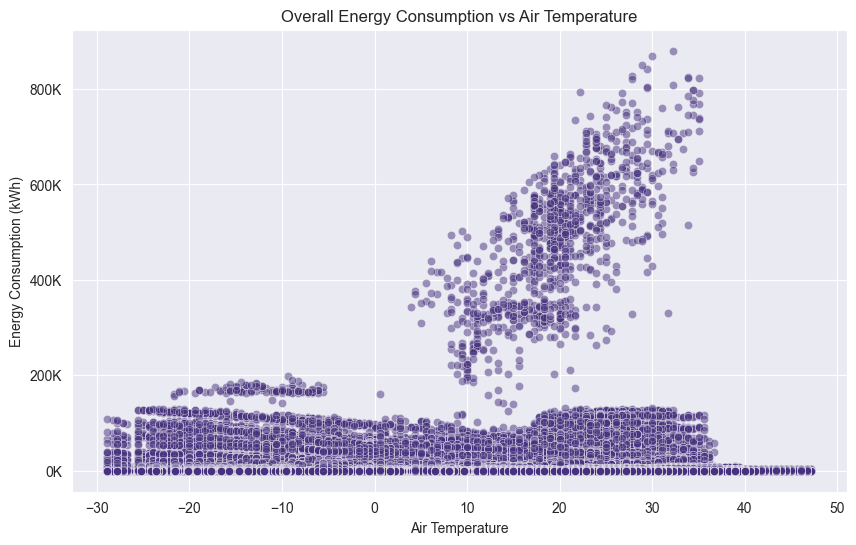

In [81]:


df_subset = df_filtered[['air_temperature', 'meter_reading']]


sns.set_style('darkgrid')
sns.set_palette('viridis')


fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df_subset, x='air_temperature', y='meter_reading', alpha=0.5, ax=ax)
ax.set_xlabel('Air Temperature')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Overall Energy Consumption vs Air Temperature')


formatter = ticker.FuncFormatter(lambda x, pos: f'{x / 1000:.0f}K')
ax.yaxis.set_major_formatter(formatter)


plt.show()


From this graph we can see that the Energy consumption is consecutivly high as the Air temperature increases and we can also a small increase in energy consumption when the air temperature is below 0 as the heater might be used very often when the temperature is below 0

In [82]:
df_filtered['primary_use'].nunique()

16

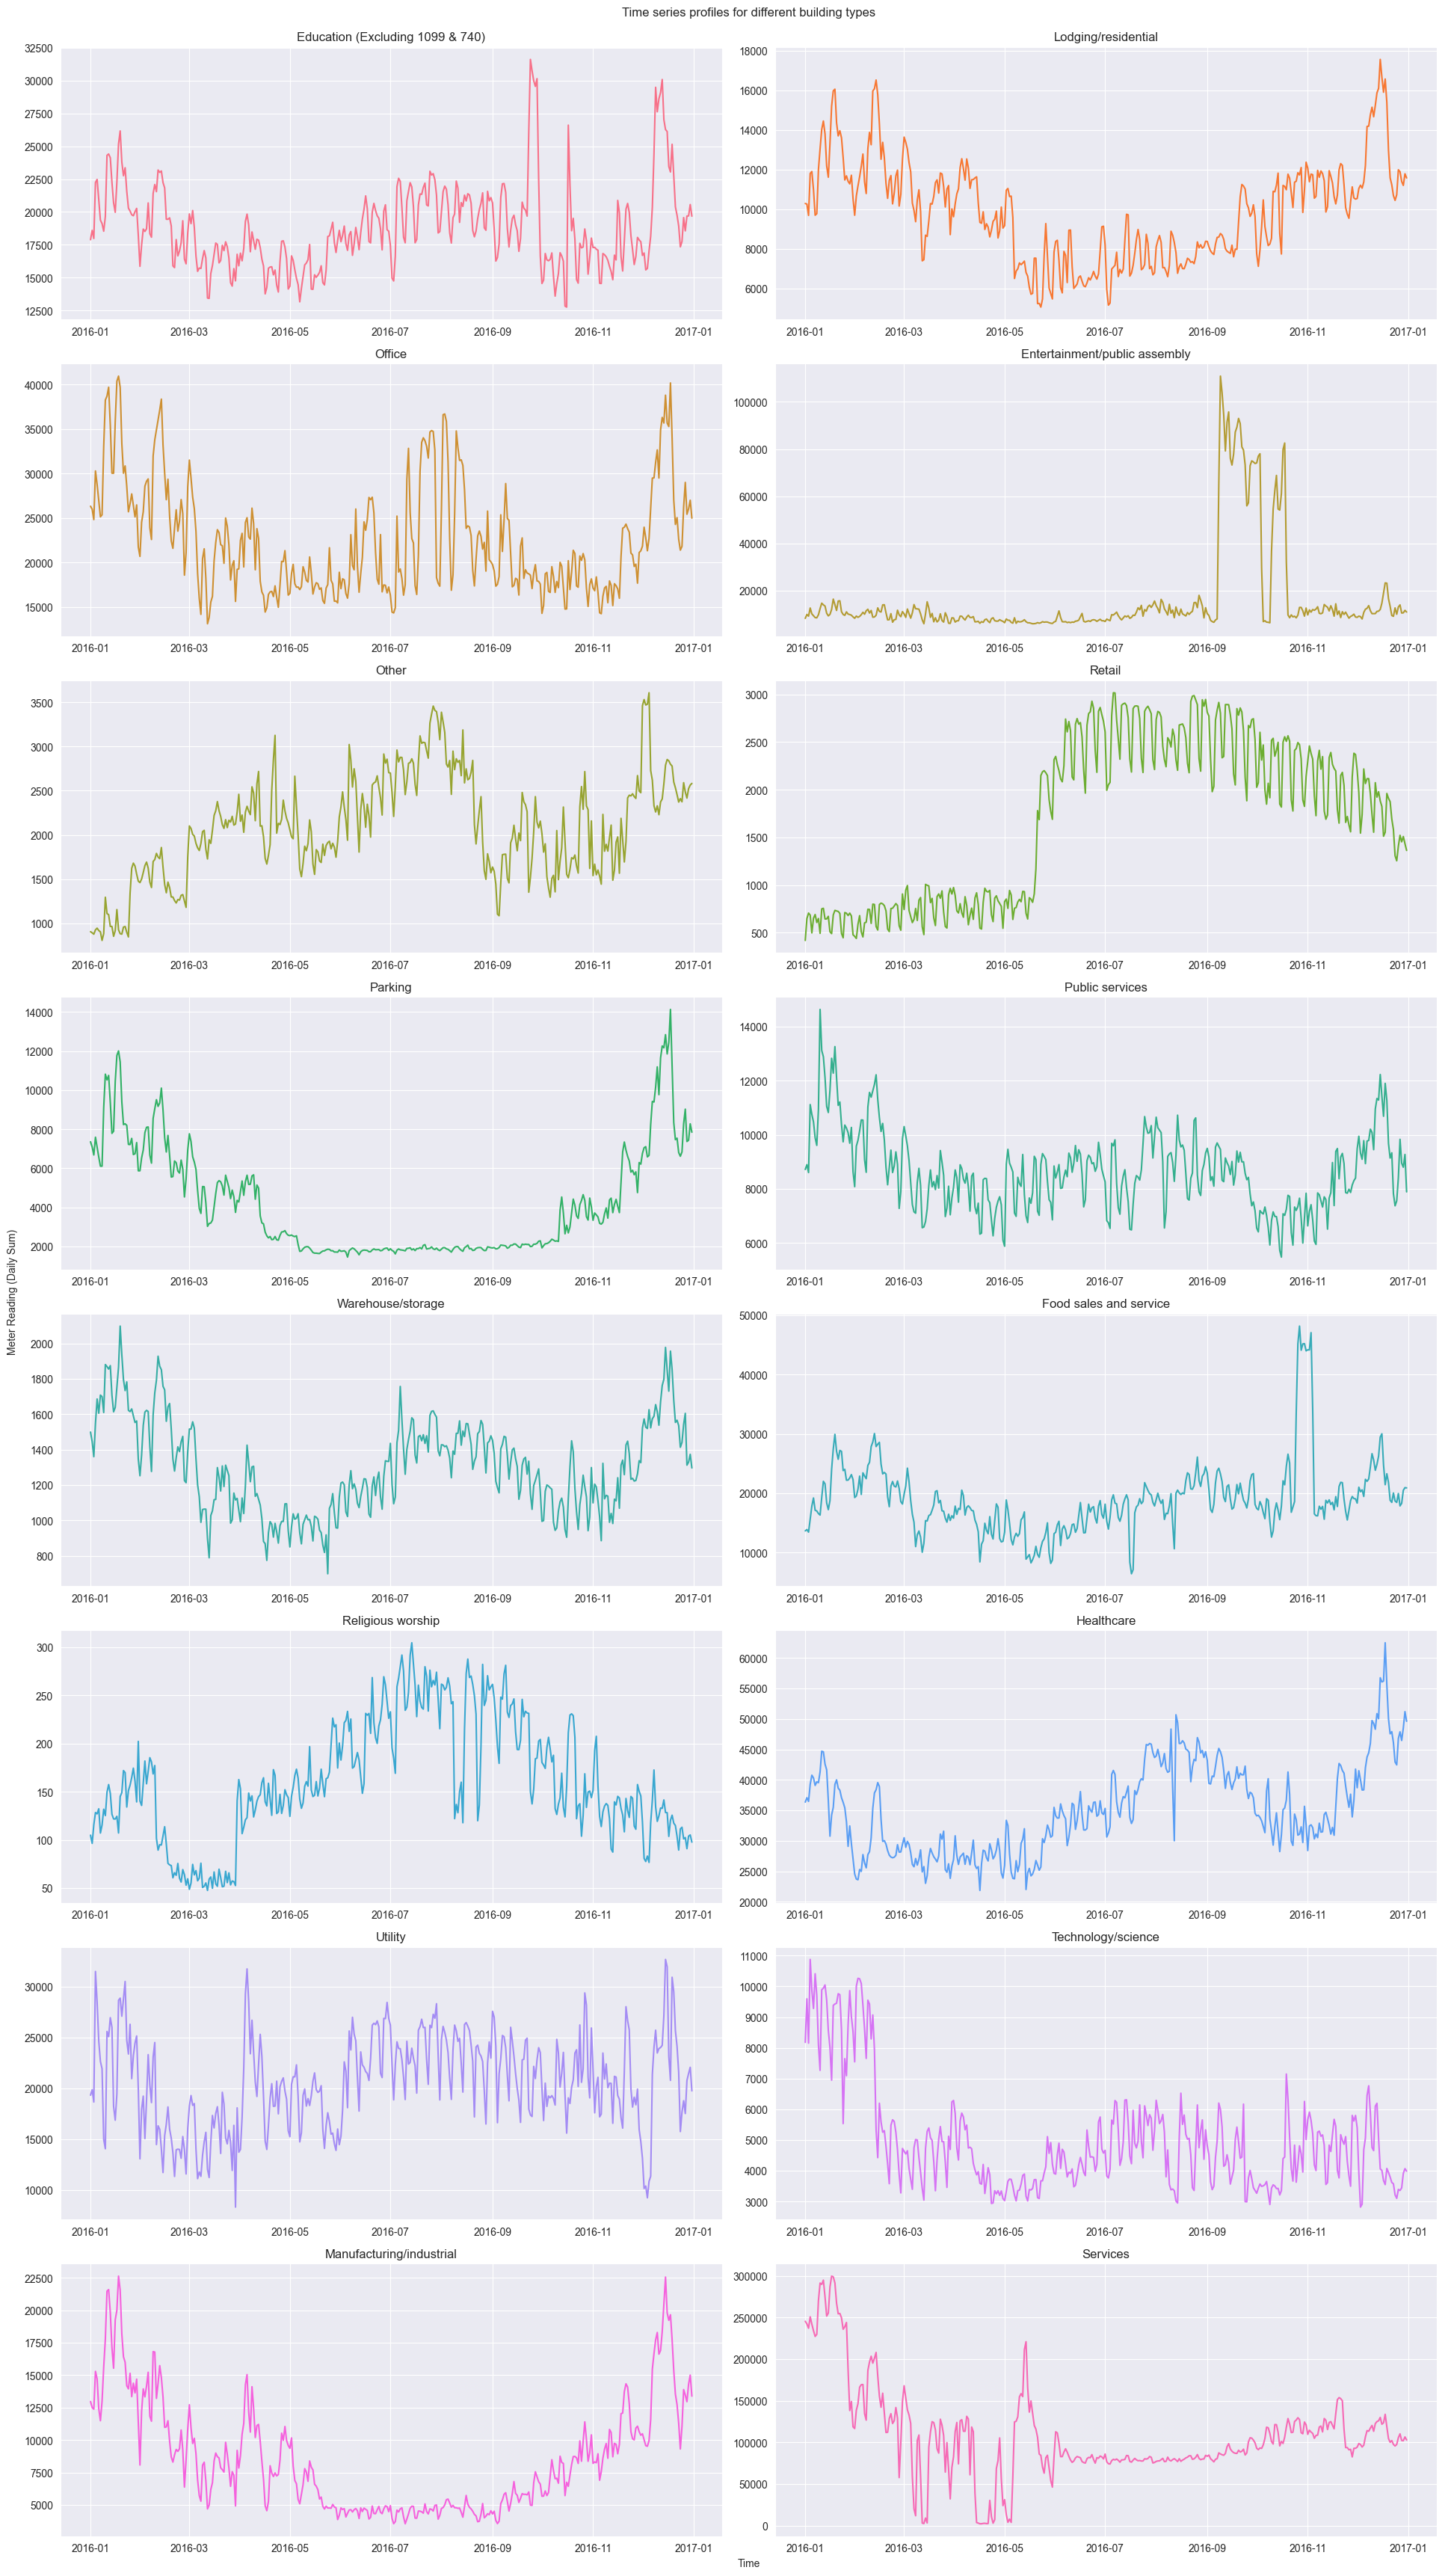

In [83]:

colors = sns.color_palette('husl', len(df['primary_use'].unique()))

fig, axes = plt.subplots(8, 2, figsize=(20, 35))

edu_df = df_filtered[(df_filtered['primary_use'] == 'Education') & (df_filtered['building_id'] != 740) & (df_filtered['building_id'] != 1099)]
edu_daily = edu_df.groupby(['building_id', edu_df['timestamp'].dt.date])['meter_reading'].sum()
edu_daily = edu_daily.reset_index()
edu_mean = edu_daily.groupby('timestamp')['meter_reading'].mean()
axes[0, 0].plot(edu_mean.index, edu_mean, color=colors[0])
axes[0, 0].set_title('Education (Excluding 1099 & 740)')

for ax, primary_use, color in zip(axes.flat[1:], df['primary_use'].unique()[1:], colors[1:]):
    use_df = df[df['primary_use'] == primary_use]
    use_daily = use_df.groupby(['building_id', use_df['timestamp'].dt.date])['meter_reading'].sum()
    use_daily = use_daily.reset_index()
    use_mean = use_daily.groupby('timestamp')['meter_reading'].mean()

    ax.plot(use_mean.index, use_mean, color=color)
    ax.set_title(primary_use)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Time')
plt.ylabel('Meter Reading (Daily Sum)', labelpad=20)
plt.title('Time series profiles for different building types', pad=30)

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


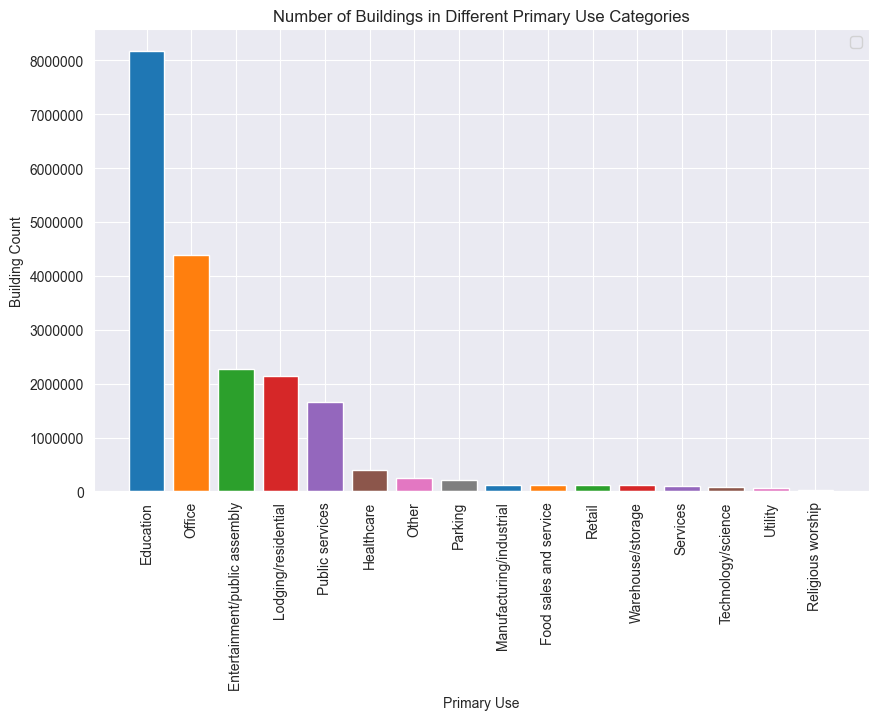

In [84]:



df_subset = df[['building_id', 'primary_use']]


filtered_df = df_subset.copy()
filtered_df.loc[(filtered_df['primary_use'] == 'Education') & ((filtered_df['building_id'] == 1099) | (filtered_df['building_id'] == 740)), 'building_id'] = None


building_counts_filtered = filtered_df['primary_use'].value_counts()


building_counts_all = df_subset['primary_use'].value_counts()


plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']  # colors for bars
plt.bar(building_counts_all.index, building_counts_all.values, color=colors[:len(building_counts_all)])

plt.xlabel('Primary Use')
plt.ylabel('Building Count')
plt.title('Number of Buildings in Different Primary Use Categories')
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')  
plt.legend()
plt.show()


In [85]:
del df_subset

**Top 5 Primary use is Education,Office,Entertainment/public assembly,Lodging/residential,Public services**

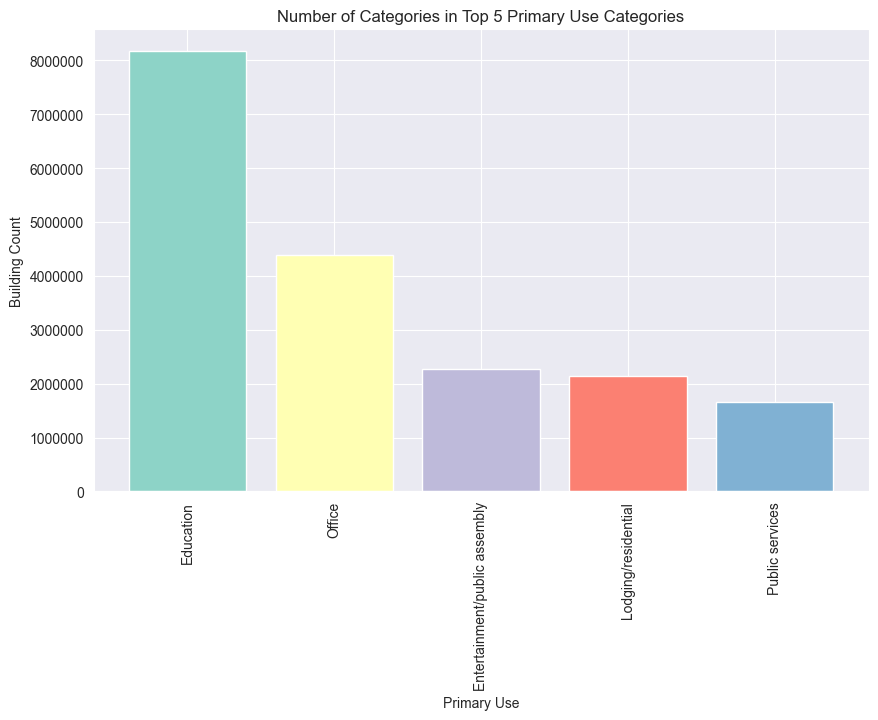

In [86]:

df_subset = df[['building_id', 'primary_use']]


building_counts = df_subset['primary_use'].value_counts()


top_5_building_counts = building_counts.head(5)


plt.figure(figsize=(10, 6))
colors = plt.cm.Set3(range(len(top_5_building_counts)))  
plt.bar(top_5_building_counts.index, top_5_building_counts.values, color=colors)
plt.xlabel('Primary Use')
plt.ylabel('Building Count')
plt.title('Number of Categories in Top 5 Primary Use Categories')
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y') 
plt.show()


Lets Calculate the average power usage by top 5 primary use cateogry 

In [90]:
import pandas as pd
import plotly.express as px

top_categories = ["Education", "Office", "Entertainment/public assembly", "Lodging/residential", "Public services"]
filtered_df = df[df['primary_use'].isin(top_categories)].copy()

filtered_df.loc[:, 'timestamp'] = pd.to_datetime(filtered_df['timestamp'])
filtered_df.loc[:, 'energy_consumption'] = filtered_df['meter_reading'] * (filtered_df['timestamp'].dt.hour + 1)
filtered_df.loc[:, 'category'] = filtered_df['primary_use'].apply(lambda x: x if x in top_categories else 'Other')

avg_power_consumption = filtered_df.groupby('category')['energy_consumption'].mean().reset_index()
avg_power_consumption['power_consumption'] = avg_power_consumption['energy_consumption'] / (filtered_df['timestamp'].dt.hour.max() + 1)

fig = px.bar(
    avg_power_consumption,
    x='category',
    y='power_consumption',
    color='category',
    color_discrete_sequence=px.colors.qualitative.Safe,
    title='Average Power Consumption by Primary Use Category'
)

fig.update_xaxes(title='Primary Use Category')
fig.update_yaxes(title='Average Power Consumption')

fig.show()
